In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
#Basic dimensions

time = np.arange(1950,2100)
rftime = np.arange(0,150)
basin = ['EAIS','WEDD','AMUN','ROSS','PENS']
bcol = ['tab:green','tab:blue','tab:red','tab:orange','tab:purple']
exp = ['EAIS','WEDD','AMUN','ROSS','PENS','TOTL','HALF','DOUB']
ssp = ['126','245','585']
esm = ['ACCESS-CM2','CAMS-CSM1-0','CAS-ESM2-0','CMCC-ESM2','CanESM5','EC-Earth3','EC-Earth3-Veg','GFDL-ESM4','INM-CM4-8','INM-CM5-0','MIROC6','MPI-ESM1-2-LR','MRI-ESM2-0','NorESM2-MM']
ism = ['CISM_NCA', 'GRIS_LSC', 'IMAU_VUB', 'ISSM_UCI', 'PISM_DMI', 'PISM_PIK']

In [3]:
#Create variables

temp = np.zeros((len(time),len(esm),len(ssp),len(basin)))
orf  = np.zeros((len(rftime),len(exp),len(basin)))
irf  = np.zeros((len(rftime),len(ism),len(basin)))
srf  = np.zeros((len(rftime),len(ism),len(basin)))

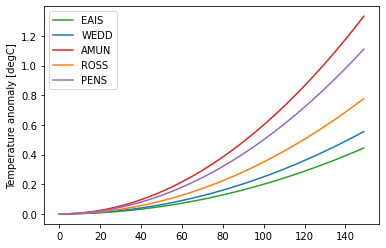

In [4]:
#Fill variables

mag = [.4,.5,1.2,.7,1.]

for e,es in enumerate(esm):
    for s,ss in enumerate(ssp):
        for b,bas in enumerate(basin):
            temp[:,e,s,b] = mag[b]*.00005*rftime**2
            
for b,bas in enumerate(basin):
    plt.plot(rftime,temp[:,0,0,b],c=bcol[b],label=bas)
plt.legend()
plt.ylabel('Temperature anomaly [degC]')
plt.show()

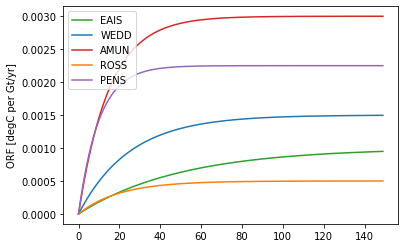

In [5]:
#Magnitude and time scale of response 

pert = 400 #Gt/yr

mag = [.4,.6,1.2,.2,.9] #degC
tsc = [50,25,15,20,10] #year

for b,bas in enumerate(basin):
    orf[:,b,b] = mag[b]*(1-np.exp(-rftime/tsc[b]))/pert

for b,bas in enumerate(basin):
    orf[:,5,b] = orf[:,b,b]

orf[:,6,:] = .5* orf[:,5,:]
orf[:,7,:] =  2* orf[:,5,:]

for b,bas in enumerate(basin):
    plt.plot(rftime,orf[:,5,b],c=bcol[b],label=bas)
plt.legend()
plt.ylabel('ORF [degC per Gt/yr]')
plt.show()

#Read orf

#Take difference from control [degC]

#Divide by perturbation 400 Gt/yr -> [degC per Gt/yr]

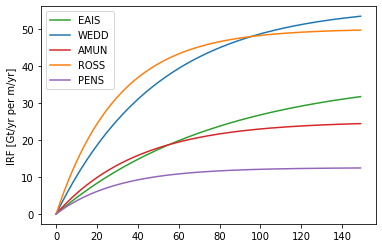

In [6]:
pert = 8 #m/yr

mag = [300,450,200,400,100] #Gt/yr
tsc = [80,50,40,30,30] #year

for b,bas in enumerate(basin):
    for i,im in enumerate(ism):
        irf[:,i,b] = mag[b]*(1-np.exp(-rftime/tsc[b]))/pert

for b,bas in enumerate(basin):
    plt.plot(rftime,irf[:,0,b],c=bcol[b],label=bas)
plt.legend()
plt.ylabel('IRF [Gt/yr per m/yr]')
plt.show()

#Read irf 

#[check basins!]

#Take difference from t=0

#Change sign negative -> positive [Gt]

#Differentiate in time -> [Gt/yr]

#Divide by perturbation 8 m/yr -> [Gt/yr per m/yr]

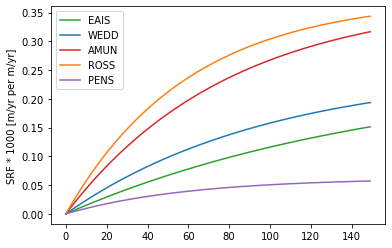

In [7]:
pert = 8 #m/yr

mag = [0.002,0.002,0.003,0.003,0.0005] #m/yr
tsc = [160,100,80,60,60] #year

for b,bas in enumerate(basin):
    for i,im in enumerate(ism):
        srf[:,i,b] = mag[b]*(1-np.exp(-rftime/tsc[b]))/pert

for b,bas in enumerate(basin):
    plt.plot(rftime,1000*srf[:,0,b],c=bcol[b],label=bas)
plt.legend()
plt.ylabel('SRF * 1000 [m/yr per m/yr]')
plt.show()

#Read srf

#Check basins!

#Ensure units [m/yr per m/yr]

In [8]:
#Save as combined netcdf file

temp2 = xr.DataArray(temp,dims=('time','esm','ssp','basin'),coords={'time':time,'esm':esm,'ssp':ssp,'basin':basin},attrs={'unit':'degrees Celcius','long_name':'temperature anomaly from pre-industrial control'})
orf2  = xr.DataArray(orf,dims=('rftime','exp','basin'),coords={'rftime':rftime,'exp':exp,'basin':basin},attrs={'unit':'degrees Celcius per Gt/yr','long_name':'ocean response function to increased mass loss'})
irf2  = xr.DataArray(irf,dims=('rftime','ism','basin'),coords={'rftime':rftime,'ism':ism,'basin':basin},attrs={'unit':'Gt/yr per m/yr','long_name':'ice mass loss response function to increased basal melt'})
srf2  = xr.DataArray(srf,dims=('rftime','ism','basin'),coords={'rftime':rftime,'ism':ism,'basin':basin},attrs={'unit':'m/yr per m/yr','long_name':'sea level response function to increased basal melt'})

ds = xr.Dataset({'temp':temp2,'orf':orf2,'irf':irf2,'srf':srf2})
ds.to_netcdf(f'../data/dummy.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 150, esm: 14, ssp: 3, basin: 5, rftime: 150, exp: 8, ism: 6)
Coordinates:
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
  * esm      (esm) <U13 'ACCESS-CM2' 'CAMS-CSM1-0' ... 'MRI-ESM2-0' 'NorESM2-MM'
  * ssp      (ssp) <U3 '126' '245' '585'
  * basin    (basin) <U4 'EAIS' 'WEDD' 'AMUN' 'ROSS' 'PENS'
  * rftime   (rftime) int64 0 1 2 3 4 5 6 7 ... 142 143 144 145 146 147 148 149
  * exp      (exp) <U4 'EAIS' 'WEDD' 'AMUN' 'ROSS' 'PENS' 'TOTL' 'HALF' 'DOUB'
  * ism      (ism) <U8 'CISM_NCA' 'GRIS_LSC' ... 'PISM_DMI' 'PISM_PIK'
Data variables:
    temp     (time, esm, ssp, basin) float64 0.0 0.0 0.0 ... 1.332 0.777 1.11
    orf      (rftime, exp, basin) float64 0.0 0.0 0.0 ... 0.006 0.0009994 0.0045
    irf      (rftime, ism, basin) float64 0.0 0.0 0.0 0.0 ... 24.4 49.65 12.41
    srf      (rftime, ism, basin) float64 0.0 0.0 0.0 ... 0.0003437 5.728e-05